# Lecture 11: Numerical optimization

[Download on GitHub](https://github.com/NumEconCopenhagen/lectures-2022)

[<img src="https://mybinder.org/badge_logo.svg">](https://mybinder.org/v2/gh/NumEconCopenhagen/lectures-2022/master?urlpath=lab/tree/11/Numerical_optimization.ipynb)

1. [Introduction](#Introduction)
2. [The rosenbrock function: Comparing optimizers](#The-rosenbrock-function:-Comparing-optimizers)
3. [Griewank function: Local minima and multistart](#Griewank-function:-Local-minima-and-multistart)
4. [Constraints](#Constraints)
5. [Interpolation](#Interpolation)
6. [Dynamic optimization problems](#Dynamic-optimization-problems)
7. [Summary](#Summary)


You will learn to solve non-convex, multi-dimensional, dynamic optimization problems using numerical optimization with multistart and nesting (**scipy.optimize**). You will learn simple function approximation using linear interpolation (**scipy.interp**). 

**Links:**

1. **scipy.optimize:** [overview](https://docs.scipy.org/doc/scipy/reference/optimize.html) + [tutorial](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)
2. **scipy.interp:** [overview](https://docs.scipy.org/doc/scipy/reference/interpolate.html) + [tutorial](https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html)

**Useful note:** [Unconstrained Numerical Optimization: An Introduction for Econometricians](https://www.dropbox.com/s/wjj5cvi3iz6pzs2/noteOptimization.pdf?dl=0) (by Anders Munk-Nielsen)

In [1]:
from types import SimpleNamespace
import time
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

<a id="Introduction"></a>

# 1. Introduction

All **optimization problems** are characterized by:

1. Control vector (choices/decisions), $\boldsymbol{x} \in \mathbb{R}^k$
2. Objective function (payoff/utility) to minimize, $f:\mathbb{R}^k \rightarrow \mathbb{R}$ (differentiable or not)
3. Constraints, i.e. $\boldsymbol{x}  \in C \subseteq \mathbb{R}^k$ (linear or non-linear interdependence)

Note that $f$ might also take other inputs (parameters or a dataset). But these are fixed and therefore not variables we optimize over.

**Maximization** is just **minimization** of $-f$. 

All **optimizers** (minimizers) follow the structure:

1. Make initial guess
2. Evaluate the function (and perhaps gradients)
3. Check for convergence
4. Update guess and return to step 2

**What is convergence?** "Small" change in function value since last iteration (or "zero" gradient).

**Characteristics** of optimizers:

1. Use gradients or not.
2. Allow for specifying bounds.
3. Allow for specifying general constraints.

**Gradients** provide useful information, but can be costly to compute (using analytical formula or numerically).

**Penalty terms** can (sometimes) instead be used to enforce bounds and constraints.

**Optimizers** it is good to know:

1. **Nelder-Mead:** 
 * **Pro:** Robust (to e.g. noise in objective function) and does not require derivatives.
 * **Con:** Slow convergence. No bounds or constraints.
2. **Newton-CG:**
 * **Pro:** Require few iterations. Very precise with analytical hessian for smooth functions.
 * **Con:** Costly computation of hessian. No bounds or constraints.
3. **BFGS:** (like newton, but with smart computation of hessian)
  * **Pro:** Require few function evaluations. 
  * **Con:** No bounds or constraints.
4. **L-BFGS-B:** Like BFGS, but allows for bounds.

5. **SLSQP:**
  * **Pro:** Bounds and constraints in multiple dimensions.
  * **Con:** Not as efficient as BFGS.

## 1.1 Gradient based optimizers

Let us look at the idea behind gradient based optimizers.

**One dimensional intuition:** Consider the second-order Taylor approximation around $x_n$:

$$ 
f_T(x) = f_T(x_n + \Delta x) \approx f(x_n)+ f^{\prime}(x_n) \Delta x + \frac{1}{2} f^{\prime\prime}(x_n) (\Delta x)^2
$$

Find the minimum wrt. to $\Delta x$ by solving the FOC:

$$
\frac{d}{d\Delta x} f_T(x) = 0 \Leftrightarrow f^{\prime}(x_n) + f^{\prime\prime}(x_n) \Delta x = 0 \Leftrightarrow \Delta x = -\frac{f^{\prime}(x_n)}{f^{\prime\prime}(x_n)}
$$

**Algorithm:** `minimize_newton()`

1. Choose tolerance $\epsilon>0$, guess on $\boldsymbol{x}_0$, compute $f(\boldsymbol{x}_0)$, and set $n=1$.
2. Compute $\nabla f(\boldsymbol{x}_{n-1})$ (gradient/jacobian) and $\boldsymbol{H}f(\boldsymbol{x}_{n-1})$ (hessian).
3. Compute new guess

  $$ 
  \boldsymbol{x}_{n} = \boldsymbol{x}_{n-1} - [\boldsymbol{H}f(\boldsymbol{x}_{n-1})]^{-1} \nabla f(\boldsymbol{x}_{n-1})
  $$

3. If $|f(\boldsymbol{x}_n)-f(\boldsymbol{x}_{n-1})| < \epsilon$ then stop.
5. Set $n = n + 1$ and return to step 2.

In [2]:
def minimize_newton(f,x0,jac,hess,max_iter=500,tol=1e-8):
    """ minimize function with Newtons' algorithm
        
    Args:

        f (callable): function
        x0 (np.ndarray): initial values
        jac (callable): jacobian
        hess (callable): hessian
        max_iter (int): maximum number of iterations
        tol (float): tolerance
        
    Returns:
    
        x (np.ndarray): minimum
        nit (int): number of iterations used        
        
    """
    
    # step 1: initialize
    x = x0
    fx = f(x0)
    nit = 1
    
    # step 2-5: iteration
    while nit < max_iter:
        
        x_prev = x
        fx_prev = fx
        
        # step 2: evaluate gradient and hessian
        jacx = jac(x_prev)
        hessx = hess(x_prev)
        
        # step 3: update x
        inv_hessx = linalg.inv(hessx)        
        x = x_prev - inv_hessx@jacx
     
        # step 4: check convergence
        fx = f(x)
        if abs(fx-fx_prev) < tol:
            break
            
        # step 5: increment n
        nit += 1
        
    return x,nit

**Algorithm:** `minimize_gradient_descent()`

1. Choose tolerance $\epsilon>0$, potential step sizes, $ \boldsymbol{\alpha} = [\alpha_0,\alpha_1,\dots,\alpha_\#]$, guess on $\boldsymbol{x}_0$, compute $f(\boldsymbol{x}_0)$, and set $n=1$.
2. Compute $\nabla f(\boldsymbol{x}_{n-1})$.
3. Find good step size:

  $$ 
  \alpha^{\ast} = \arg \min_{\alpha \in \boldsymbol{\alpha}}  f(\boldsymbol{x}_{n-1} - \alpha \nabla f(\boldsymbol{x}_{n-1}))
  $$

4. Compute new guess:

  $$
  \boldsymbol{x}_{n} = \boldsymbol{x}_{n-1} - \alpha^{\ast} \nabla f(\boldsymbol{x}_{n-1})
  $$

5. If $|f(\boldsymbol{x}_n)-f(\boldsymbol{x}_{n-1})| < \epsilon$ then stop.
6. Set $n = n + 1$ and return to step 2.

In [3]:
def minimize_gradient_descent(f,x0,jac,alphas=[0.01,0.05,0.1,0.25,0.5,1],max_iter=500,tol=1e-8):
    """ minimize function with gradient descent
        
    Args:

        f (callable): function
        x0 (np.ndarray): initial values
        jac (callable): jacobian
        alpha (list): potential step sizes
        max_iter (int): maximum number of iterations
        tol (float): tolerance
        
    Returns:
    
        x (np.ndarray): minimum
        nit (int): number of iterations used
        nfev (int): number of function evaluations used
        njev (int): number of jacobian evaluations used
        
    """
    
    # step 1: initialize
    x = x0
    fx = f(x0)
    nit = 1
    nfev = 1
    njev = 0
    
    # step 2-6: iteration
    while nit < max_iter:
            
        x_prev = x
        fx_prev = fx
        
        # step 2: evaluate gradient
        jacx = jac(x)
        njev += 1
        
        # step 3: find good step size (line search)
        fx_ast = np.inf
        x_ast = np.nan
        alpha_ast = np.nan
        for alpha in alphas:
            x = x_prev - alpha*jacx
            fx = f(x)
            nfev += 1
            if fx < fx_ast:
                alpha_ast = alpha
                x_ast = x                
                fx_ast = fx
        
        # step 4: update guess
        x = x_ast # = x_prev - alpha_ast*jacx
                            
        # step 5: check convergence
        fx = fx_ast # = f(x)
        if abs(fx-fx_prev) < tol:
            break
            
        # d. update i
        nit += 1
        
    return x,nit,nfev,njev

**Many generalizations:**

1. Use both Hessian and line search
2. Stop line search when improvement found
3. Limit attention to a "trust-region"

etc. etc. etc. etc.

<a id="The-rosenbrock-function:-Comparing-optimizers"></a>

# 2. The rosenbrock function: Comparing optimizers

Consider the **rosenbrock function**:

$$ 
f(\boldsymbol{x}) = f(x_1,x_2) =0.5(1-x_{1})^{2}+(x_{2}-x_{1}^{2})^{2}
$$

with **jacobian** (gradient)

$$ 
\nabla f(\boldsymbol{x})=\begin{bmatrix}\frac{\partial f}{\partial x_{1}}\\
\frac{\partial f}{\partial x_{2}}
\end{bmatrix}=\begin{bmatrix}-(1-x_{1})-4x_{1}(x_{2}-x_{1}^{2})\\
2(x_{2}-x_{1}^{2})
\end{bmatrix}
$$

and **hessian**:

$$
\boldsymbol{H}f(\boldsymbol{x})=\begin{bmatrix}\frac{\partial f}{\partial x_{1}x_{1}} & \frac{\partial f}{\partial x_{1}x_{2}}\\
\frac{\partial f}{\partial x_{1}x_{2}} & \frac{\partial f}{\partial x_{2}x_{2}}
\end{bmatrix}=\begin{bmatrix}1-4x_{2}+12x_{1}^{2} & -4x_{1}\\
-4x_{1} & 2
\end{bmatrix}
$$

**Global minimum** is at $(1,1)$ where $f(1,1)=0$.

**Check jacobian and hessian:**

In [4]:
x1 = sm.symbols('x_1')
x2 = sm.symbols('x_2')
f = 0.5*(1.0-x1)**2 + (x2-x1**2)**2

In [5]:
Df = sm.Matrix([sm.diff(f,i) for i in [x1,x2]])
Df

Matrix([
[-4*x_1*(-x_1**2 + x_2) + 1.0*x_1 - 1.0],
[                     -2*x_1**2 + 2*x_2]])

In [6]:
Hf = sm.Matrix([[sm.diff(f,i,j) for j in [x1,x2]] for i in [x1,x2]])
Hf

Matrix([
[12*x_1**2 - 4*x_2 + 1.0, -4*x_1],
[                 -4*x_1,      2]])

**Implementation:**

In [7]:
def _rosen(x1,x2):
    return 0.5*(1.0-x1)**2+(x2-x1**2)**2
def rosen(x):
    return _rosen(x[0],x[1])
def rosen_jac(x):
    return np.array([-(1.0-x[0])-4*x[0]*(x[1]-x[0]**2),2*(x[1]-x[0]**2)])
def rosen_hess(x):
    return np.array([[1-4*x[1]+12*x[0]**2,-4*x[0]],[-4*x[0],2]])

**3D Plot:**

C:\Users\gmf123\AppData\Local\Temp\ipykernel_12928\936720320.py:21: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cs);


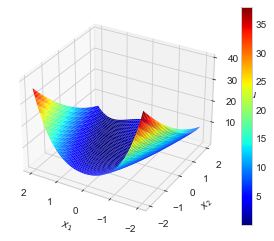

In [8]:
# a. grids
x1_vec = np.linspace(-2,2,500)
x2_vec = np.linspace(-2,2,500)
x1_grid,x2_grid = np.meshgrid(x1_vec,x2_vec,indexing='ij')
rosen_grid = _rosen(x1_grid,x2_grid)

# b. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(x1_grid,x2_grid,rosen_grid,cmap=cm.jet)

# c. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$u$')

# d. invert xaxis
ax.invert_xaxis()

# e. add colorbar
fig.colorbar(cs);

**Contour plot:**

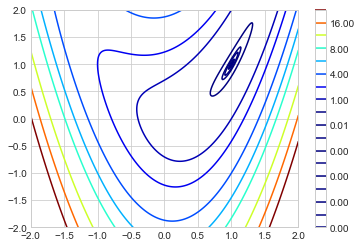

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
levels = [1e-6,5*1e-6,1e-5,5*1e-5,1e-4,5*1e-4,1e-3,5*1e-3,1e-2,5*1e-2,1,2,4,6,8,12,16,20]
cs = ax.contour(x1_grid,x2_grid,rosen_grid,levels=levels,cmap=cm.jet)
fig.colorbar(cs);

**Newton:**

In [10]:
x0 = np.array([5,4])
x,nit = minimize_newton(rosen,x0,rosen_jac,rosen_hess)
print(nit,x,rosen(x))

6 [1. 1.] 0.0


**Gradient descent:**

In [11]:
x0 = np.array([5,4])
x,nit,nfev,njev = minimize_gradient_descent(rosen,x0,rosen_jac,alphas=[0.01,0.05,0.1,0.25,0.5,1])
print(nit,nfev,njev,x,rosen(x))

173 1039 173 [1.00020519 1.00053964] 3.7750814497569406e-08


**Task 1:** Can you improve the algorithm by playing around with the `alphas`?

**Task 2:** What happens if the search for `alpha_ast` terminates when a improvement in the function value has been found?

**Task 3:** Could you implement the algorithm without knowing the jacobian?

## 2.1 Scipy minimizers

**Preperation I:** Function for collecting infomation while running optimizing:

In [12]:
# complicated -> not necessary to understand it
def collect(x):
    
    # globals used to keep track across iterations
    global nit # set nit = 0 before calling optimizer
    global x0
    global x1s
    global x2s
    global fs
    
    # a. initialize list
    if nit == 0:
        x1s = [x0[0]] 
        x2s = [x0[1]]
        fs = [rosen(x0)]
        
    # b. append trial values
    x1s.append(x[0])
    x2s.append(x[1])
    fs.append(rosen(x))
    
    # c. increment number of evaluations
    nit += 1
    

**Preperation II:** Function plotting the collected information:

In [13]:
# complicated -> not necessary to understand it
def contour():
    
    global nit
    global x1s
    global x2s
    global fs
    
    # a. contour plot
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1,2,1)
    levels = [1e-6,5*1e-6,1e-5,5*1e-5,1e-4,5*1e-4,1e-3,5*1e-3,1e-2,5*1e-2,1,2,4,6,8,12,16,20]
    cs = ax.contour(x1_grid,x2_grid,rosen_grid,levels=levels,cmap=cm.jet)
    fig.colorbar(cs)
    ax.plot(x1s,x2s,'-o',ms=4,color='black')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    
    # b. function value
    ax = fig.add_subplot(1,2,2)
    ax.plot(np.arange(nit+1),fs,'-o',ms=4,color='black')
    ax.set_xlabel('iteration')
    ax.set_ylabel('function value')
    

**Nelder-Mead**

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 57
         Function evaluations: 105


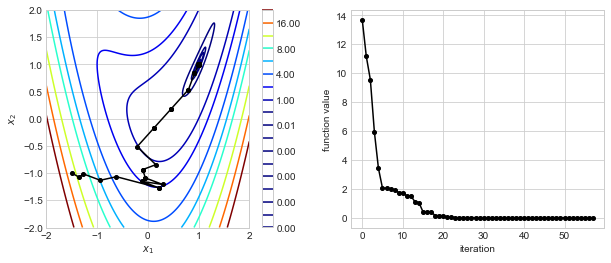

In [14]:
nit = 0 # global used in "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,
                           method='Nelder-Mead',
                           callback=collect, # call function collect() before each iteration
                           options={'disp':True}) # display the results
contour()

> **Note:** Does not require a gradient. Slow convergence close to target.
>
> **Iterations:** How many steps the algorithm has taken.
>
> **Function evaluations:** Will be higher than iterations. Used to compute next step.

We can also **print the information on results:**

In [15]:
print(result)

 final_simplex: (array([[0.9999932 , 0.99998507],
       [1.00000809, 1.00003102],
       [1.00003176, 1.00007406]]), array([2.48761443e-11, 2.53004854e-10, 6.15284951e-10]))
           fun: 2.4876144250933352e-11
       message: 'Optimization terminated successfully.'
          nfev: 105
           nit: 57
        status: 0
       success: True
             x: array([0.9999932 , 0.99998507])


We can also acess specific information of the result object: 

In [16]:
result.nit

57

**Newton** (with analytical hessian)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
         Hessian evaluations: 11


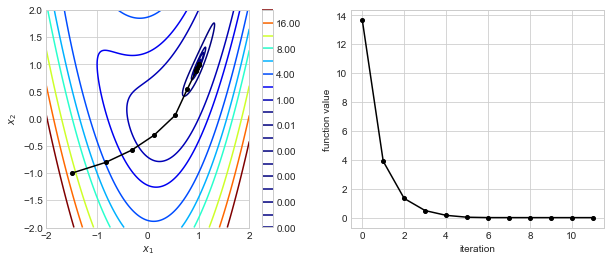

In [17]:
nit = 0 # global used in "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,jac=rosen_jac,hess=rosen_hess,
                           method='Newton-CG',
                           callback=collect,
                           options={'disp':True})
contour()

> **Note:** Smoother and faster.

**Newton** (with numerical hessian computed by scipy)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 36
         Hessian evaluations: 0


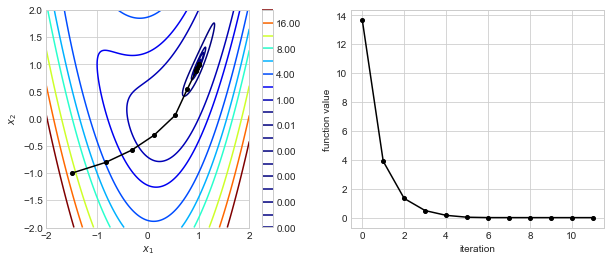

In [18]:
nit = 0 # global used in "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,jac=rosen_jac,
                           method='Newton-CG',
                           callback=collect,
                           options={'disp':True})
contour()

> **Note:** Same as above, but gradient evaluations instead of hessian evaluations.

**BFGS** (with analytical gradient)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14


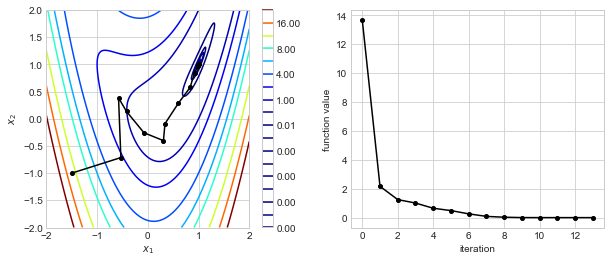

In [19]:
nit = 0 # global used in "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,jac=rosen_jac,
                           method='BFGS',
                           callback=collect,
                           options={'disp':True})
contour()

> **Note:** Non-smooth, but fast. Very low number of function evaluations.

**BFGS** (with numerical gradient computed by scipy)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 42
         Gradient evaluations: 14


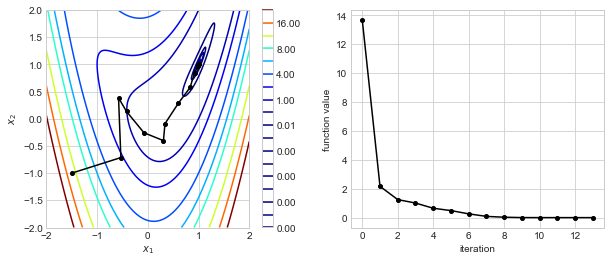

In [20]:
nit = 0 # global used in "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0, # no jac= specified
                           method='BFGS',
                           callback=collect,
                           options={'disp':True})
contour()

> **Note:** Same as above, but more function evaluations.

**L-BFGS-B** (with analytical gradient)

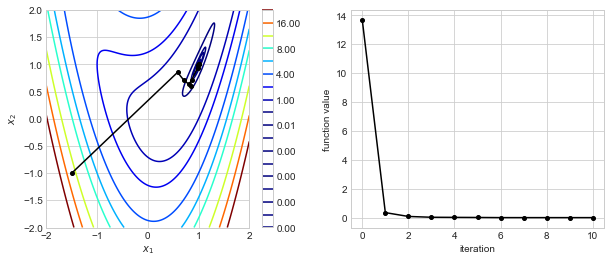

In [21]:
nit = 0 # global used in "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,jac=rosen_jac,
                           method='L-BFGS-B',
                           bounds=((-3,3),(-3,3)),
                           callback=collect,
                           options={'disp':True})
contour()

**SLSQP**

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.7296908855910356e-09
            Iterations: 10
            Function evaluations: 13
            Gradient evaluations: 10


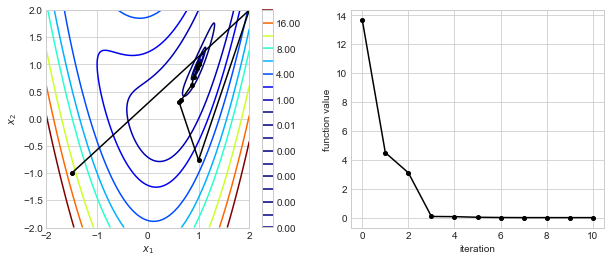

In [22]:
nit = 0 # global used in "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,jac=rosen_jac,
                           method='SLSQP',
                           bounds=((-2,2),(-2,2)),
                           callback=collect,
                           options={'disp':True})
contour()

## 2.2 Controling the optimizers

> **Note:** See the settings for each optimizer in the [documention](https://docs.scipy.org/doc/scipy/reference/optimize.html).

We can lower the **tolerance**:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 14
         Function evaluations: 45
         Gradient evaluations: 15


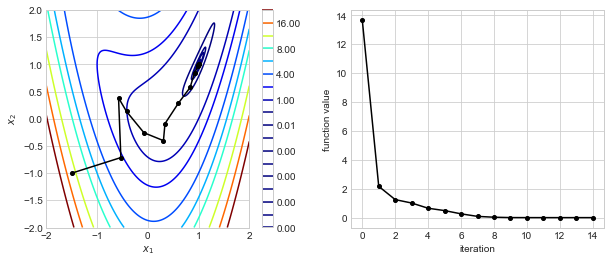

In [23]:
nit = 0
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,
                           method='BFGS',
                           callback=collect,
                           options={'disp':True,'gtol':1e-8}) # note this
contour()

We can change the **maximum number of iterations**:

         Current function value: 0.486266
         Iterations: 5
         Function evaluations: 18
         Gradient evaluations: 6


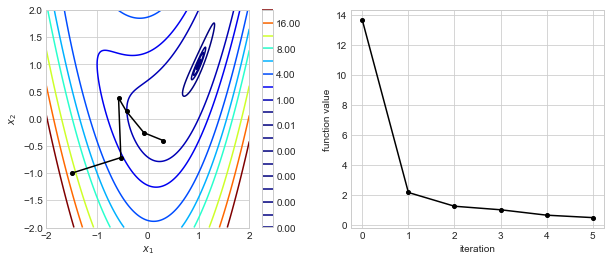

In [24]:
nit = 0
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,
                           method='BFGS',
                           callback=collect,
                           options={'disp':True,'maxiter':5}) # note this and warning
contour()

**Question:** Can we make the program stop if the optimizer is not sure it has found a maximum?

<a id="Griewank-function:-Local-minima-and-multistart"></a>

# 3. Griewank function: Local minima and multistart

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+2$$

The **global minimum** of this function is $f(0,0) = 0$. But the function also have a lot of **local minima**. How to avoid these?

In [25]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(1))
    return A-B+1

Test global minimum:

In [26]:
griewank(np.zeros(2))

0.0

## 3.1 3D plot

In [-600,600] x [-600,600]:


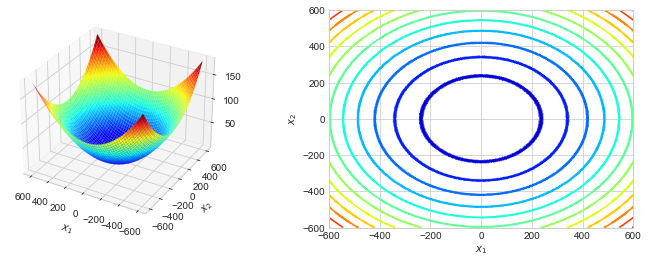

In [-5,5] x [-5,5]:


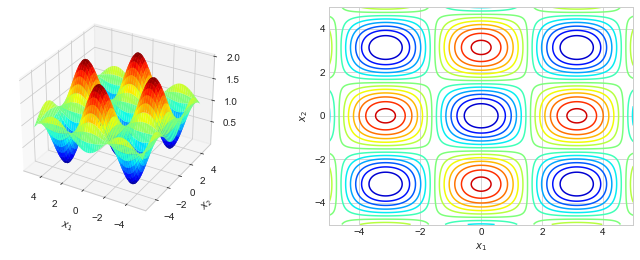

In [-1,1] x [-1,1]:


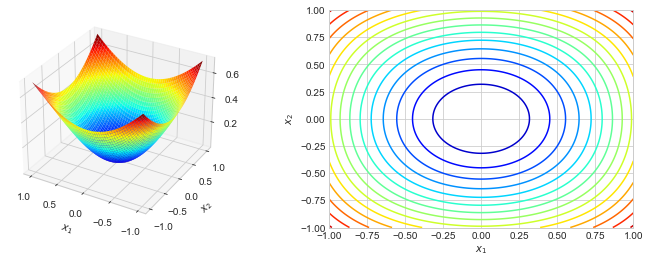

In [27]:
for bound in [600,5,1]:
    
    print(f'In [{-bound},{bound}] x [{-bound},{bound}]:')
    
    # a. grids
    x1_vec = np.linspace(-bound,bound,1000)
    x2_vec = np.linspace(-bound,bound,1000)
    x1_grid_griewank,x2_grid_griewank = np.meshgrid(x1_vec,x2_vec,indexing='ij')
    griewank_grid = griewank_(x1_grid_griewank,x2_grid_griewank)

    # b. main
    fig = plt.figure(figsize=(12,4))
    
    # 3D
    ax = fig.add_subplot(1,2,1,projection='3d')
    cs = ax.plot_surface(x1_grid_griewank,x2_grid_griewank,griewank_grid,cmap=cm.jet)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.invert_xaxis()
    
    # contour
    ax = fig.add_subplot(1,2,2)
    cs = ax.contour(x1_vec,x2_vec,griewank_grid,levels=15,cmap=cm.jet)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    
    plt.show()

## 3.2 Multi-start

**Multi-start:** Draw many random starting values:

In [28]:
np.random.seed(1986)
x0s = -600 + 1200*np.random.uniform(size=(5000,2)) # in [-600,600]
xs = np.empty((5000,2))
fs = np.empty(5000)

In [29]:
print(f'min(x0s) = {np.min(x0s):.2f}, max(x0s) = {np.max(x0s):.2f}')

min(x0s) = -599.82, max(x0s) = 599.99


Try to solve with **BFGS** starting from each of these:

In [30]:
fopt = np.inf
xopt = np.nan
for i,x0 in enumerate(x0s):
    
    # a. optimize
    result = optimize.minimize(griewank,x0,method='BFGS',tol=1e-8)
    xs[i,:] = result.x
    f = result.fun
    
    # b. print first 10 or if better than seen yet
    if i < 10 or f < fopt: # plot 10 first or if improving
        if f < fopt:
            fopt = f
            xopt = xs[i,:]
            
        print(f'{i:4d}: x0 = ({x0[0]:7.2f},{x0[1]:7.2f})',end='')
        print(f' -> converged at ({xs[i][0]:7.2f},{xs[i][1]:7.2f}) with f = {f:12.8f}')
        
# best solution
print(f'\nbest solution:\n x = ({xopt[0]:7.2f},{xopt[1]:7.2f}) -> f = {fopt:12.8f}')

   0: x0 = (  82.65,-507.19) -> converged at (  81.64,-508.68) with f =  66.38903667
   1: x0 = ( 130.18, 477.00) -> converged at ( 131.88, 477.28) with f =  61.32846302
   2: x0 = (  53.89, 243.27) -> converged at (  53.38, 241.78) with f =  15.33462113
   3: x0 = (-136.64, 181.99) -> converged at (-138.16, 182.12) with f =  13.07067667
   4: x0 = ( 228.06, 262.36) -> converged at ( 229.22, 260.62) with f =  30.13156447
   5: x0 = ( 228.22, 368.17) -> converged at ( 229.22, 367.38) with f =  46.90141331
   6: x0 = (-259.50, 309.21) -> converged at (-141.30, 279.46) with f =  24.52846525
   7: x0 = (-230.91, -74.51) -> converged at (-232.36, -75.36) with f =  14.92523628
   8: x0 = (  63.24, -80.57) -> converged at (  62.80, -81.64) with f =   2.65359622
   9: x0 = (  93.14, 470.65) -> converged at (  94.20, 471.00) with f =  57.70816887
  25: x0 = (  56.57,-134.77) -> converged at (  53.38,  -3.14) with f =   0.71518870
  57: x0 = ( -28.14,  -4.62) -> converged at ( -28.26,  -3.14) wi

The solver, wrongly, **converges to many of the local minima**:

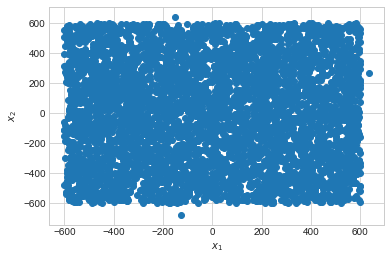

In [31]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(xs[:,0],xs[:,1])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

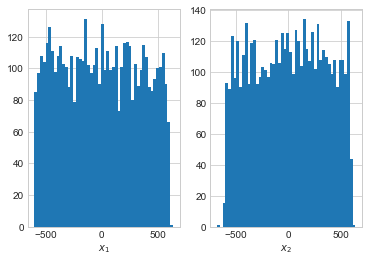

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax.hist(xs[:,0],bins=50)
ax.set_xlabel('$x_1$');

ax = fig.add_subplot(1,2,2)
ax.hist(xs[:,1],bins=50)
ax.set_xlabel('$x_2$');

## 3.3 Is there a better solution than multi-start?

**In short:** No.

**Potential improvement:** Use information from previous run to determine, where to look next. Fundamental trade-off between:

1. **Exploitation.** Focus on areas where previous evaluations returned low function values.
2. **Exploration.** Focus on completely new areas. 

**Heuristic:** If the same optimum is obtained for many starting values, this is a good sign for it being the global optimum.

**Further discussion**: [Benchmarking Global Optimizers](https://fguvenendotcom.files.wordpress.com/2019/09/agk2019-september-nber-submit.pdf) ([code](https://github.com/serdarozkan/TikTak#tiktak))

<a id="Constraints"></a>

# 4. Constraints

## 4.1 In general

Consider the **constrained problem**:

$$
\min_{x_1,x_2,x_3,x_4} x_1x_4(x_1+x_2+x_3) + x_3
$$

subject to

$$
\begin{aligned}
x_1x_2x_3x_4 &\geq 25 \\
x_1^2+x_2^2+x_3^2+x_4^2 &= 40 \\
1 \leq x_1,x_2,x_3,x_4 &\leq 5
\end{aligned}
$$

Define **objective** and **constraints**:

In [33]:
def _objective(x1,x2,x3,x4):
    return x1*x4*(x1+x2+x3)+x3

def objective(x):
    return _objective(x[0],x[1],x[2],x[3])

def ineq_constraint(x):
    return x[0]*x[1]*x[2]*x[3]-25.0 # violated if negative

def eq_constraint(x):
    return 40.0 - np.sum(x**2) # must equal zero

In [34]:
# a. setup
bound = (1.0,5.0)
bounds = (bound, bound, bound, bound)
ineq_con = {'type': 'ineq', 'fun': ineq_constraint} 
eq_con = {'type': 'eq', 'fun': eq_constraint}

# b. call optimizer
x0 = (40**(1/8),40**(1/8),40**(1/8),40**(1/8)) # fit the equality constraint
result = optimize.minimize(objective,x0,
                             method='SLSQP',
                             bounds=bounds,
                             constraints=[ineq_con,eq_con],
                             options={'disp':True})

print('\nx = ',result.x)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 17.014017289044375
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9

x =  [1.         4.74299968 3.82114992 1.3794083 ]


**Alternative:** Extend the objective function with a *penalty term*, where guesses outside the allowed bounds and constraints are projected into the allowed region, but a (large) penalty term is added to discourage this. Solve this problem with an unconstrained solver.

## 4.2 Economic application

Consider the following **consumption-saving problem**:

$$
\begin{aligned}
V(a_0) &= \max_{c_1,c_2,c_3} \frac{c_{1}^{1-\rho}}{1-\rho} + \beta \frac{c_{2}^{1-\rho}}{1-\rho} + \beta^2\frac{c_{3}^{1-\rho}}{1-\rho} + \beta^2\nu\frac{(a_{3}+\kappa)^{1-\rho}}{1-\rho}\\
&\text{s.t.}&\\
m_1 &= (1+r)a_0 + y_1\\
a_1 &= m_1-c_1\\
m_2 &= (1+r)a_1 + y_2\\
a_2 &= m_2-c_2\\
m_3 &= (1+r)a_2 + y_3\\
a_3 &= m_3-c_3\\
c_1,c_2,c_3 &\geq 0\\
a_1,a_2,a_3 &\geq 0\\
\end{aligned}
$$

where 

* $m_t$ is cash-on-hand in period $t\in\{1,2,\dots,T\}$
* $c_t$ is consumption $t$
* $a_t$ is end-of-period assets and income in period $t$
* ${y_t}$ is income in period $t$
* $\beta > 0$ is the discount factor
* $r > -1$ is the interest rate 
* $\rho > 1$ is the CRRA coefficient
* $\nu > 0 $ is the strength of the bequest motive
* $\kappa > 0$ is the degree of luxuriousness in the bequest motive  
* $a_t\geq0$ is a no-borrowing constraint.

**First order conditions:**

* Period 1: If $a_1 > 0$ then $c_1^{-\rho} = \beta(1+r)c_2^{-\rho}$.
* Period 2: If $a_2 > 0$ then $c_2^{-\rho} = \beta(1+r)c_3^{-\rho}$.
* Period 3: If $a_3 > 0$ then $c_3^{-\rho} = \nu(a_3+\kappa)^{-\rho}$.

**Guide to solve such problem:**

1. Setup parameters
2. Formulate objective function
3. Determine how to handle constraints
4. Call optimizer

**Parameters:**

In [35]:
par = SimpleNamespace()
par.a0 = 0.5
par.beta = 0.94
par.r = 0.04
par.rho = 8
par.kappa = 0.5
par.nu = 0.1
par.T = 3
par.y = np.arange(1,par.T+1) # = [1,2,3]

**Objetive function:**

In [36]:
def evaluate(c,par,penalty_factor=10_000):
    """ evaluate model and calculate utility and penalty if constraints are not satisfies """
    
    # a. allocate
    a = np.zeros(par.T) # end-of-period assets
    m = np.zeros(par.T) # cash-on-hand
    cb = np.zeros(par.T) # bounded consumption, defined below
    
    # b. bound consumption and penalty
    penalty = 0.0
    for t in range(par.T): # period-by-period
        
        # i. lagged assets
        a_lag = a[t-1] if t > 0 else par.a0
        
        # ii. cash-on-hand
        m[t] = (1+par.r)*a_lag + par.y[t]
        
        # ii. bound consumption
        if c[t] < 0.0: # too low
            cb[t] = 0.0
            penalty += penalty_factor*np.abs(c[t]-0.0)            
        elif c[t] > m[t]: # too high
            cb[t] = m[t]
            penalty += penalty_factor*np.abs(c[t]-m[t])
        else: # just fine
            cb[t] = c[t]
        
        # d. end-of-period assets 
        a[t] = m[t] - cb[t]
            
    # c. utility
    total_utility = 0.0
    
    # i. consumption
    for t in range(par.T):
        discounting = par.beta**t
        per_period_utility = cb[t]**(1-par.rho)/(1-par.rho)
        total_utility += discounting*per_period_utility
    
    # ii. bequest
    discounting = par.beta**(par.T-1)
    bequest_utility = par.nu*(a[-1]+par.kappa)**(1-par.rho)/(1-par.rho)
    total_utility += discounting*bequest_utility
        
    # d. return
    return total_utility,penalty,m,a
    
def obj(c,par,penalty_factor=10_000):
    """ gateway to evaluate() for optimizer """
    
    utility,penalty,_m,_a = evaluate(c,par,penalty_factor)
    
    return -utility + penalty


**Solve:**

In [37]:
def solve(par,tol=1e-8):
    
    # a. initial geuss
    x0 = par.a0/par.T*np.ones(par.T)
    
    # b. solve
    t0 = time.time()
    results = optimize.minimize(obj,x0,args=(par,),method='Nelder-Mead',options={'xatol':tol,'fatol':tol,'maxiter':50_000})
    
    if not results.success:
        print(results)
        raise ValueError
    
    print(f'solved model in {time.time()-t0:.3f} secs [{results.nit} iterations, {results.nfev} function evaluations]\n')
    
    # c. details
    c = results.x
    total_utility,penalty,m,a = evaluate(c,par)
    assert np.isclose(penalty,0.0)
    
    print(f't =  0: a = {par.a0:.4f}')
    for t in range(par.T):
        print(f't = {t+1:2d}: y = {par.y[t]:7.4f}, m = {m[t]:7.4f}, c = {c[t]:7.4f}, a = {a[t]:7.4f} ')    
    
    print(f'\ntotal utility = {total_utility:.8f} [penalty = {penalty:.4f}]\n')
    
    for t in range(par.T):
        
        if t < par.T-1:
            foc_error = c[t]**(-par.rho) - par.beta*(1+par.r)*c[t+1]**(-par.rho)
        else:
            foc_error = c[t]**(-par.rho) - par.nu*(a[t]+par.kappa)**(-par.rho)
            
        print(f'FOC error in period {t+1:2d}: {foc_error:12.8f}')
    

In [38]:
solve(par)

solved model in 0.027 secs [306 iterations, 561 function evaluations]

t =  0: a = 0.5000
t =  1: y =  1.0000, m =  1.5200, c =  1.5200, a =  0.0000 
t =  2: y =  2.0000, m =  2.0000, c =  2.0000, a =  0.0000 
t =  3: y =  3.0000, m =  3.0000, c =  2.0001, a =  0.9999 

total utility = -0.01039479 [penalty = 0.0000]

FOC error in period  1:   0.03127676
FOC error in period  2:   0.00008879
FOC error in period  3:   0.00000134


**What happens if the income path is reversed?**

In [39]:
par.y = list(reversed(par.y))
solve(par)

solved model in 0.017 secs [193 iterations, 354 function evaluations]

t =  0: a = 0.5000
t =  1: y =  3.0000, m =  3.5200, c =  1.9145, a =  1.6055 
t =  2: y =  2.0000, m =  3.6698, c =  1.9090, a =  1.7607 
t =  3: y =  1.0000, m =  2.8312, c =  1.9036, a =  0.9275 

total utility = -0.00540710 [penalty = 0.0000]

FOC error in period  1:   0.00000000
FOC error in period  2:  -0.00000000
FOC error in period  3:   0.00000000


**Question:** Could we easily extend the problem to more periods?

$$
\begin{aligned}
V(a_0) &= \max_{c_1,c_2,\dots c_T} \sum_{t=1}^T \beta^{t-1} \frac{c_{t}^{1-\rho}}{1-\rho} + \beta^{T+1}\nu\frac{(a_{T}+\kappa)^{1-\rho}}{1-\rho}\\
&\text{s.t.}&\\
m_t &= (1+r)a_{t-1} + y_t\\
c_t &\geq 0\\
a_t &\geq 0
\end{aligned}
$$

**Follow-up question:** What is the problem for $T \rightarrow \infty$?

**Central limit of problem type considered:** No uncertainty/risk.

<a id="Interpolation"></a>

# 5. Interpolation

**Intermezzo:** To consider dynamic optimization problems, we need to think about interpolation.

**Inputs:**

1. Sorted vector of known points (grid vector), $G = \{G_i\}_{i=0}^{n-1}$
2. Vector of known values (at these points), $F = \{F_i = f(G_i)\}_{i=0}^{n-1}$
3. A new point, `x`

**Algorithm:** `linear_interpolate()`
1. Determine `i`  such that

$$
G_i \leq x < G_{i+1}
$$

2. Compute interpolated value by

$$
y =  F_{i} + \frac{F_{i+1}-F_{i}}{G_{i+1}-G_{i}}(x-G_{i})
$$

**Extrapolation:**

1. Below where $x < G_1$: 

$$
y =  F_{0} + \frac{F_{1}-F_{0}}{G_{1}-G_{0}}(x-G_{0})
$$

2. Above where $x > G_{n-2}$: 

$$
y =  F_{n-2} + \frac{F_{n-1}-F_{n-2}}{G_{n-1}-G_{n-2}}(x-G_{n-2})
$$

In [40]:
def linear_interpolate(G,F,x):
    """ linear interpolation (and extrapolation)
    
    Args:
    
        G (np.ndarray): known points
        F (np.ndarray): known values
        x (float): point to be interpolated
        
    Returns:
    
        y (float): intepolated value
    
    """
    
    assert len(G) == len(F)
    n = len(G)
    
    # a. find index in known points
    if x < G[1]: # exprapolation below
        i = 0
    elif x > G[-2]: # extrapolation above
        i = n-2
    else: # true interpolation
        
        # search
        i = 0 
        while x >= G[i+1] and i < n-1:
            i += 1
        
        assert x >= G[i]
        assert x < G[i+1]

    # b. interpolate
    diff_G = G[i+1]-G[i]
    diff_F = F[i+1]-F[i]
    slope = diff_F/diff_G
    y = F[i] + slope*(x-G[i])
    
    return y

## 5.1 Example

Consider the following function and known points:

In [41]:
f = lambda x: (x-3)**3 - 3*x**2 + 5*x

G = np.linspace(-5,10,6)
F = f(G)

**Simple test:**

In [42]:
for x in [-2.3,4.1,7.5,9.1]:
    true = f(x)
    y = linear_interpolate(G,F,x)
    print(f'x = {x:4.1f} -> true = {true:6.1f}, interpolated = {y:6.1f}')

x = -2.3 -> true = -176.2, interpolated = -193.5
x =  4.1 -> true =  -28.6, interpolated =  -27.7
x =  7.5 -> true =  -40.1, interpolated =  -24.5
x =  9.1 -> true =   24.1, interpolated =   50.7


**Scipy.interpolate:** Use the *RegularGridInterpolator*  

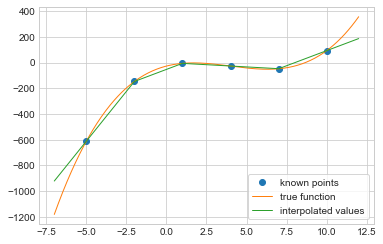

In [43]:
# a. construct interpolation function
interp_func = interpolate.RegularGridInterpolator([G],F,
                                                  bounds_error=False,
                                                  fill_value=None)

# bounds_error=False and fill_value=None allow for extrapolation

# b. interpolate
grid = np.linspace(-7,12,500)
interp_values = interp_func(grid)

# c. evaluate true values
true_values = f(grid)

# d. plot true and interpolated values
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(G,F,'o',label='known points')
ax.plot(grid,true_values,'-',lw=1,label='true function')
ax.plot(grid,interp_values,'-',lw=1,label='interpolated values')
ax.legend(loc='lower right',facecolor='white',frameon=True);

**Task:** Increase the number of known points and see what happens.

**Note:**

1. Linear interpolation works best when the function does not curve too much.
2. Extrapolation is much worse than interpolation.

**Multiple dimensions:** Same principle, ``interpolate.RegularGridInterpolator([G1,G2,G3],F)``.

<a id="Dynamic-optimization-problems"></a>

# 6. Dynamic optimization problems

The following subject is _hard_. But also extremely useful. If you master this, you can solve (almost) all economic models you meet on your way in life.

## 6.1 Problem formulation

Consider a **household** living in two periods.

In the **second period** it gets utility from **consuming** and **leaving a bequest** (warm glow),

$$
\begin{aligned}
v_{2}(m_{2})&= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\nu\frac{(a_2+\kappa)^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
a_2 &= m_2-c_2 \\
a_2 &\geq 0
\end{aligned}
$$

where 

* $m_2$ is cash-on-hand 
* $c_2$ is consumption
* $a_2$ is end-of-period assets 
* $\rho > 1$ is the risk aversion coefficient
* $\nu > 0 $ is the strength of the bequest motive
* $\kappa > 0$ is the degree of luxuriousness in the bequest motive  
* $a_2\geq0$ ensures the household *cannot* die in debt

The **value function** $v(m_2)$ measures the household's value of having $m_2$ at the beginning of period 2.

In [44]:
def utility(c,par):
    return c**(1-par.rho)/(1-par.rho)

def bequest(m,c,par):
    return par.nu*(m-c+par.kappa)**(1-par.rho)/(1-par.rho)

def v_last_period(c,m,par):
    return utility(c,par) + bequest(m,c,par)

In the **first period**, the household gets utility from consuming and takes into account that it will also live in the next-period, where it receives a stochastic income,

$$
\begin{aligned}
v_1(m_1)&=\max_{c_1}\frac{c_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2)\right]\\&\text{s.t.}&\\
a_1&=m_1-c_1\\
m_2&= (1+r)a_1+y_2 \\
y_{2}&= \begin{cases}
1+\Delta & \text{with prob. }p\\
1-\Delta & \text{with prob. }1-p 
\end{cases}\\
a_1&\geq0
\end{aligned}
$$

where

* $m_1$ is cash-on-hand in period 1
* $c_1$ is consumption in period 1
* $a_1$ is end-of-period assets in period 1
* $\beta > 0$ is the discount factor
* $\mathbb{E}_1$ is the expectation operator conditional on information in period 1
* $y_2$ is income in period 2
* $\Delta \in (0,1)$ is the level of income risk (mean-preserving if $p = 0.5$)
* $r$ is the interest rate
* $a_1\geq0$ ensures the household *cannot* borrow

In [45]:
def v(c,m,par,v_plus_interp):
    
    # a. expected value
    v_plus = 0.0
    for p,y in [(par.p,1+par.Delta),((1.0-par.p,1-par.Delta))]:
        
        # i. next period cash-on-hand
        a = m-c
        m_plus = (1+par.r)*a + y
        
        # ii. next-period values
        v_plus_now = v_plus_interp([m_plus])[0]
        
        # iii. probability weighted sum
        v_plus += p*v_plus_now
    
    # b. total value
    return utility(c,par) + par.beta*v_plus

**Our goal:** Find the value functions, $v_2(m_2)$ and $v_1(m_1)$, and associated consumption functions, $c^{\ast}_2(m_2)$ and $c^{\ast}_1(m_1)$ on some grid for $m$.

## 6.2 Solve household problem

Choose **parameters**:

In [46]:
par = SimpleNamespace()

# preferences
par.rho = 8.0
par.nu = 0.1
par.kappa = 0.5
par.beta = 0.94

# return and income
par.r = 0.04
par.p = 0.5
par.Delta = 0.5

# grid
par.Nm = 500 # number of grid points for m
par.m_min = 1e-4 # minimum value for m
par.m_max = 5.0 # maximum value for m

**Solve second period:**

In [47]:
def solve_last_period(par):

    # a. allocate
    m_grid = np.linspace(par.m_min,par.m_max,par.Nm)
    v_func = np.empty(par.Nm)
    c_func = np.empty(par.Nm)

    # b. solve
    for i,m in enumerate(m_grid):

        # i. objective
        obj = lambda x: -v_last_period(x[0],m,par)

        # ii. optimizer
        x0 = m/2 # initial value
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-8,m),))

        # iii. save
        v_func[i] = -result.fun
        c_func[i] = result.x
        
    return m_grid,v_func,c_func

**Solve:**

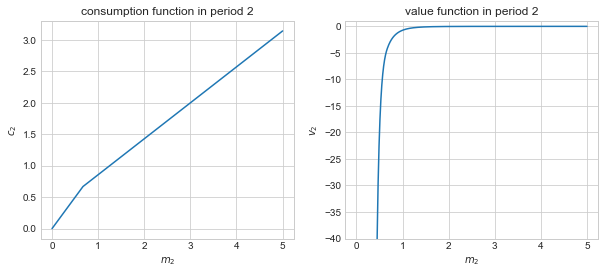

In [48]:
m2_grid,v2_func,c2_func = solve_last_period(par)

# illustration
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.plot(m2_grid,c2_func)
ax.set_xlabel('$m_2$')
ax.set_ylabel('$c_2$')
ax.set_title('consumption function in period 2')

ax = fig.add_subplot(1,2,2)
ax.plot(m2_grid,v2_func)
ax.set_xlabel('$m_2$')
ax.set_ylabel('$v_2$')
ax.set_title('value function in period 2')
ax.set_ylim([-40,1]);

**Note:** We now solve for the consumption function, rather than a specific optimum.

**Question:** Why is there a kink in the consumption function?

**Construct interpolator:**

In [49]:
v2_func_interp = interpolate.RegularGridInterpolator([m2_grid],v2_func,bounds_error=False,fill_value=None)

**Solve first period:**

In [50]:
def solve_single_period(par,v_plus_interp):

    # a. allocate
    m_grid = np.linspace(par.m_min,par.m_max,par.Nm)
    v_func = np.empty(par.Nm)
    c_func = np.empty(par.Nm)
    
    # b. solve
    for i,m in enumerate(m_grid):
        
        # i. objective
        obj = lambda x: -v(x[0],m,par,v_plus_interp)
        
        # ii. solve
        x0 = m/2 # initial guess
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-8,m),))
        
        # iv. save
        v_func[i] = -result.fun
        c_func[i] = result.x[0]
     
    return m_grid,v_func,c_func

**Solve:**

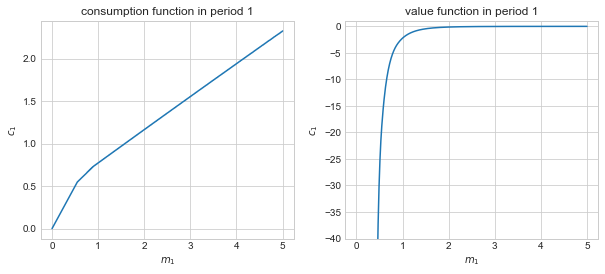

In [51]:
m1_grid,v1_func,c1_func = solve_single_period(par,v2_func_interp)

# illustrate
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.plot(m1_grid,c1_func)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('consumption function in period 1')

ax = fig.add_subplot(1,2,2)
ax.plot(m1_grid,v1_func)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('value function in period 1')
ax.set_ylim([-40,1]);

**Summary:** We can summarize what we have done in a single function doing:

1. Solve period 2 (i.e. find $v_2(m_2)$ og $c_2(m_2)$)
2. Construct interpolator of $v_2(m_2)$
3. Solve period 1 (i.e. find $v_1(m_1)$ og $c_1(m_1)$)

In [52]:
def solve(par):
    
    # a. solve period 2
    m2_grid,v2_func,c2_func = solve_last_period(par)
    
    # b. construct interpolator
    v2_func_interp = interpolate.RegularGridInterpolator([m2_grid], v2_func,
        bounds_error=False,fill_value=None)
    
    # b. solve period 1
    m1_grid,v1_func,c1_func = solve_single_period(par,v2_func_interp)
    
    return m1_grid,c1_func,m2_grid,c2_func

**Plot consumption function for various level of income risk**, i.e varios $\Delta$

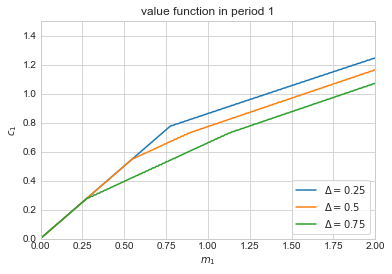

In [53]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

_Delta = par.Delta
for Delta in [0.25,0.50,0.75]:
    par.Delta = Delta
    m1_grid,c1_func,m2_grid,c2_func = solve(par)
    ax.plot(m1_grid,c1_func,label=f'$\Delta = {Delta}$')
    par.Delta = _Delta # reset
    
ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('value function in period 1')
ax.set_xlim([0,2])
ax.set_ylim([0,1.5]);

**Main takeaway:** The household lowers its consumption when risk increases (such as in a recession). This is called **precautionary saving**.

**Task:** Discuss how to extend the consumer problem in some way or another.

## 6.3 Increasing the number of periods

In [54]:
def solve_many_periods(par):
    
    t0 = time.time()
    
    # a. allocate
    m = np.zeros((par.T,par.Nm))
    v = np.zeros((par.T,par.Nm))
    c = np.zeros((par.T,par.Nm))
    
    # b. iterate
    for t in reversed(range(par.T)):
        
        t0_ = time.time()
        
        if t == par.T-1:
            
            m[t,:],v[t,:],c[t,:] = solve_last_period(par)
            
        else:
    
            # i. construct interpolator
            v_plus_interp = interpolate.RegularGridInterpolator([m[t+1,:]],v[t+1,:],
                bounds_error=False,fill_value=None)
    
            # ii. solve period
            m[t,:],v[t,:],c[t,:] = solve_single_period(par,v_plus_interp)
        
        print(f'period {t} solved in {time.time()-t0_:5.1f} secs')
        
    print(f'model solved in {time.time()-t0:5.1f} secs')
    
    return m,c
                

**Solve:**

In [55]:
par.T = 10
m_grids,c_funcs = solve_many_periods(par)

period 9 solved in   1.2 secs
period 8 solved in   7.6 secs
period 7 solved in   7.9 secs
period 6 solved in   5.5 secs
period 5 solved in   4.7 secs
period 4 solved in   4.0 secs
period 3 solved in   2.7 secs
period 2 solved in   2.5 secs
period 1 solved in   2.3 secs
period 0 solved in   2.4 secs
model solved in  40.9 secs


**Plot:**

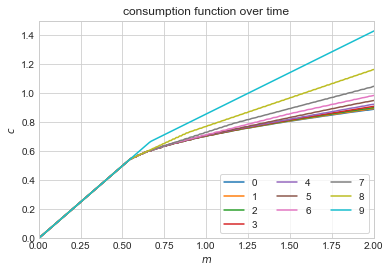

In [56]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for t in range(par.T):
    ax.plot(m_grids[t,:],c_funcs[t,:],label=f'{t}')

ax.legend(loc='lower right',facecolor='white',ncol=3,frameon=True)
ax.set_xlabel('$m$')
ax.set_ylabel('$c$')
ax.set_title('consumption function over time')
ax.set_xlim([0,2])
ax.set_ylim([0,1.5]);

## 6.4 Simulation

**Step 1:** Construct interpolators from solution:

In [57]:
c_interps = []
for t in range(par.T):
    c_interp = interpolate.RegularGridInterpolator([m_grids[t,:]],c_funcs[t,:],bounds_error=False,fill_value=None)
    c_interps.append(c_interp)


**Step 2:** Draw initail distribution of lagged assets $a_0$ and simulate forward

In [58]:
# a. allocate
simN = 10_000

sim_m = np.zeros((par.T,simN))
sim_y = np.zeros((par.T,simN))
sim_c = np.zeros((par.T,simN))
sim_a = np.zeros((par.T,simN))

# b. simulate
a0 = np.random.exponential(size=simN) # arbitrary choice of distribution
for t in range(par.T):
    
    # i. lagged assets
    if t == 0:
        a_lag = a0
    else:
        a_lag = sim_a[t-1,:]
    
    # ii. income
    p_vec = [par.p,1-par.p]
    y_vec = [1+par.Delta,1-par.Delta]
    sim_y[t,:] = np.random.choice(y_vec,p=p_vec,size=simN)
    
    # iii. cash-on-hand
    sim_m[t] = (1+par.r)*a_lag + sim_y[t,:]
    
    # iv. consumption-saving
    sim_c[t,:] = c_interps[t](sim_m[t,:])
    sim_a[t,:] = sim_m[t,:]-sim_c[t,:]

**Step 3:** Plot distributions

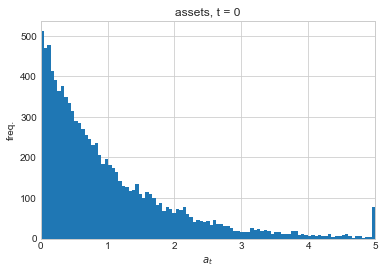

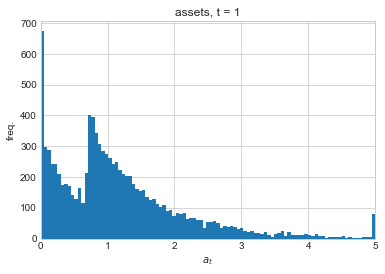

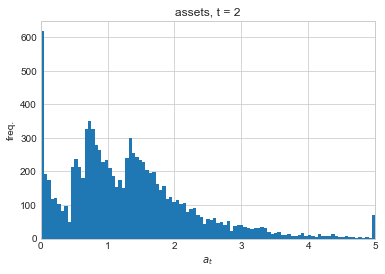

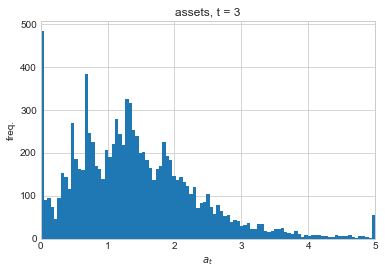

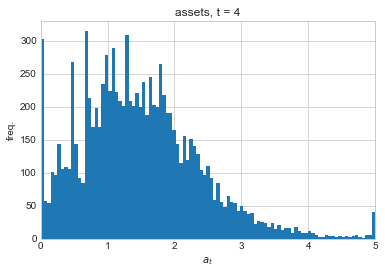

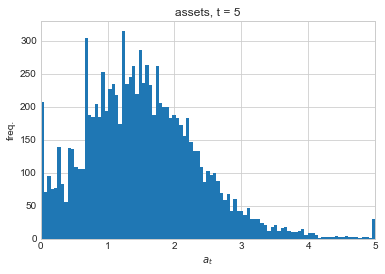

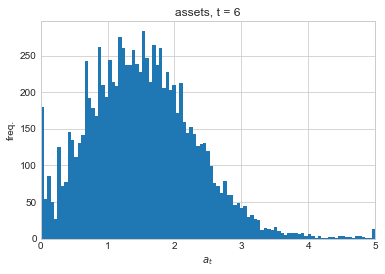

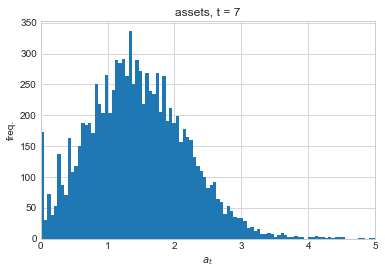

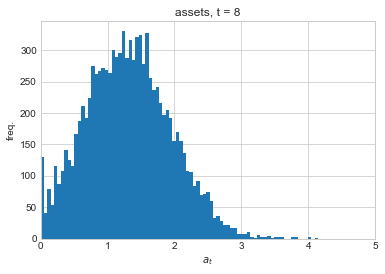

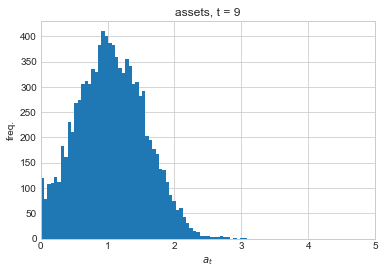

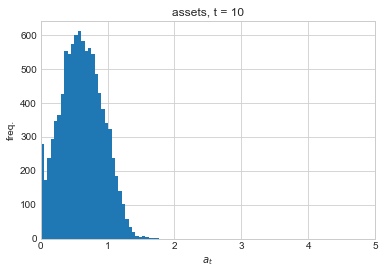

In [59]:
for t in range(-1,par.T):
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    bins = np.linspace(0,5,100)
    if t == -1:
        ax.hist(np.fmin(a0,5),bins=bins)
    else:
        ax.hist(np.fmin(sim_a[t,:],5),bins=bins)
        
    ax.set_title(f'assets, t = {t+1}')
    ax.set_xlabel('$a_t$')
    ax.set_ylabel('freq.')
    ax.set_xlim([0,5])

**Conclusion:** You can now solve models with complex heterogeneity and uncertainty, and simulate the implied dynamics. By introducing various policies you can quantify their effect not just for the average, but for the full distribution.

<a id="Summary"></a>

# 7. Summary

**This lecture:**

1. Solving multidimensional optimization problems with and without gradients (and hessians)
2. Using multistart to alleviate problems with local minima (due to non-convexities)
3. Using penalty terms to solve constrained optimization problems 
4. Linear interpolation between known points
5. Solving dynamic optimization problems backwards period-by-period 

**Dynamic optimization:** Extremely useful technique. Can handle multiple periods, multiple states and choices, more shocks etc. You can solve general equilibrium models where the households solve such problems.

**Master courses:**

1. *Dynamic Programming - Theory, Computation, and Empirical Applications* by [Bertel Schjerning](https://bschjerning.com/)
1. *Advanced Macroeconomics: Heterogenous Agent Models* by [Jeppe Druedahl](https://sites.google.com/view/jeppe-druedahl/)
1. *Household Behavior over the Life Cycle* by [Thomas Høgholm Jørgensen](https://www.tjeconomics.com/)

**Next lecture:** Canonical Economic Models.